Processed 60 patients with valid data
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - loss: 0.4237 - mean_io_u_1: 0.4964 - val_loss: 0.5233 - val_mean_io_u_1: 0.4965
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - loss: 0.2139 - mean_io_u_1: 0.4965 - val_loss: 0.3377 - val_mean_io_u_1: 0.4965
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - loss: 0.1581 - mean_io_u_1: 0.4965 - val_loss: 0.2096 - val_mean_io_u_1: 0.4965
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 328ms/step - loss: 0.1233 - mean_io_u_1: 0.4965 - val_loss: 0.1508 - val_mean_io_u_1: 0.4965
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - loss: 0.1012 - mean_io_u_1: 0.4966 - val_loss: 0.1135 - val_mean_io_u_1: 0.4965
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - loss: 0.0853 - mean_io_u_1: 0.4964 - val_loss: 0.0913 - val_mean_io_u_1: 0.4965
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 334ms/step - loss: 0.0732 - mean_io_u_1: 0.4964 - val_loss: 0.0788 - val_mean_io_u_1: 0.4965
Epoch 8/50
60/60 

Model successfully saved as 'trained_attention_unet.h5'

=== Validation Set Performance ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Dice Coefficient: 0.7824
IoU: 0.6426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


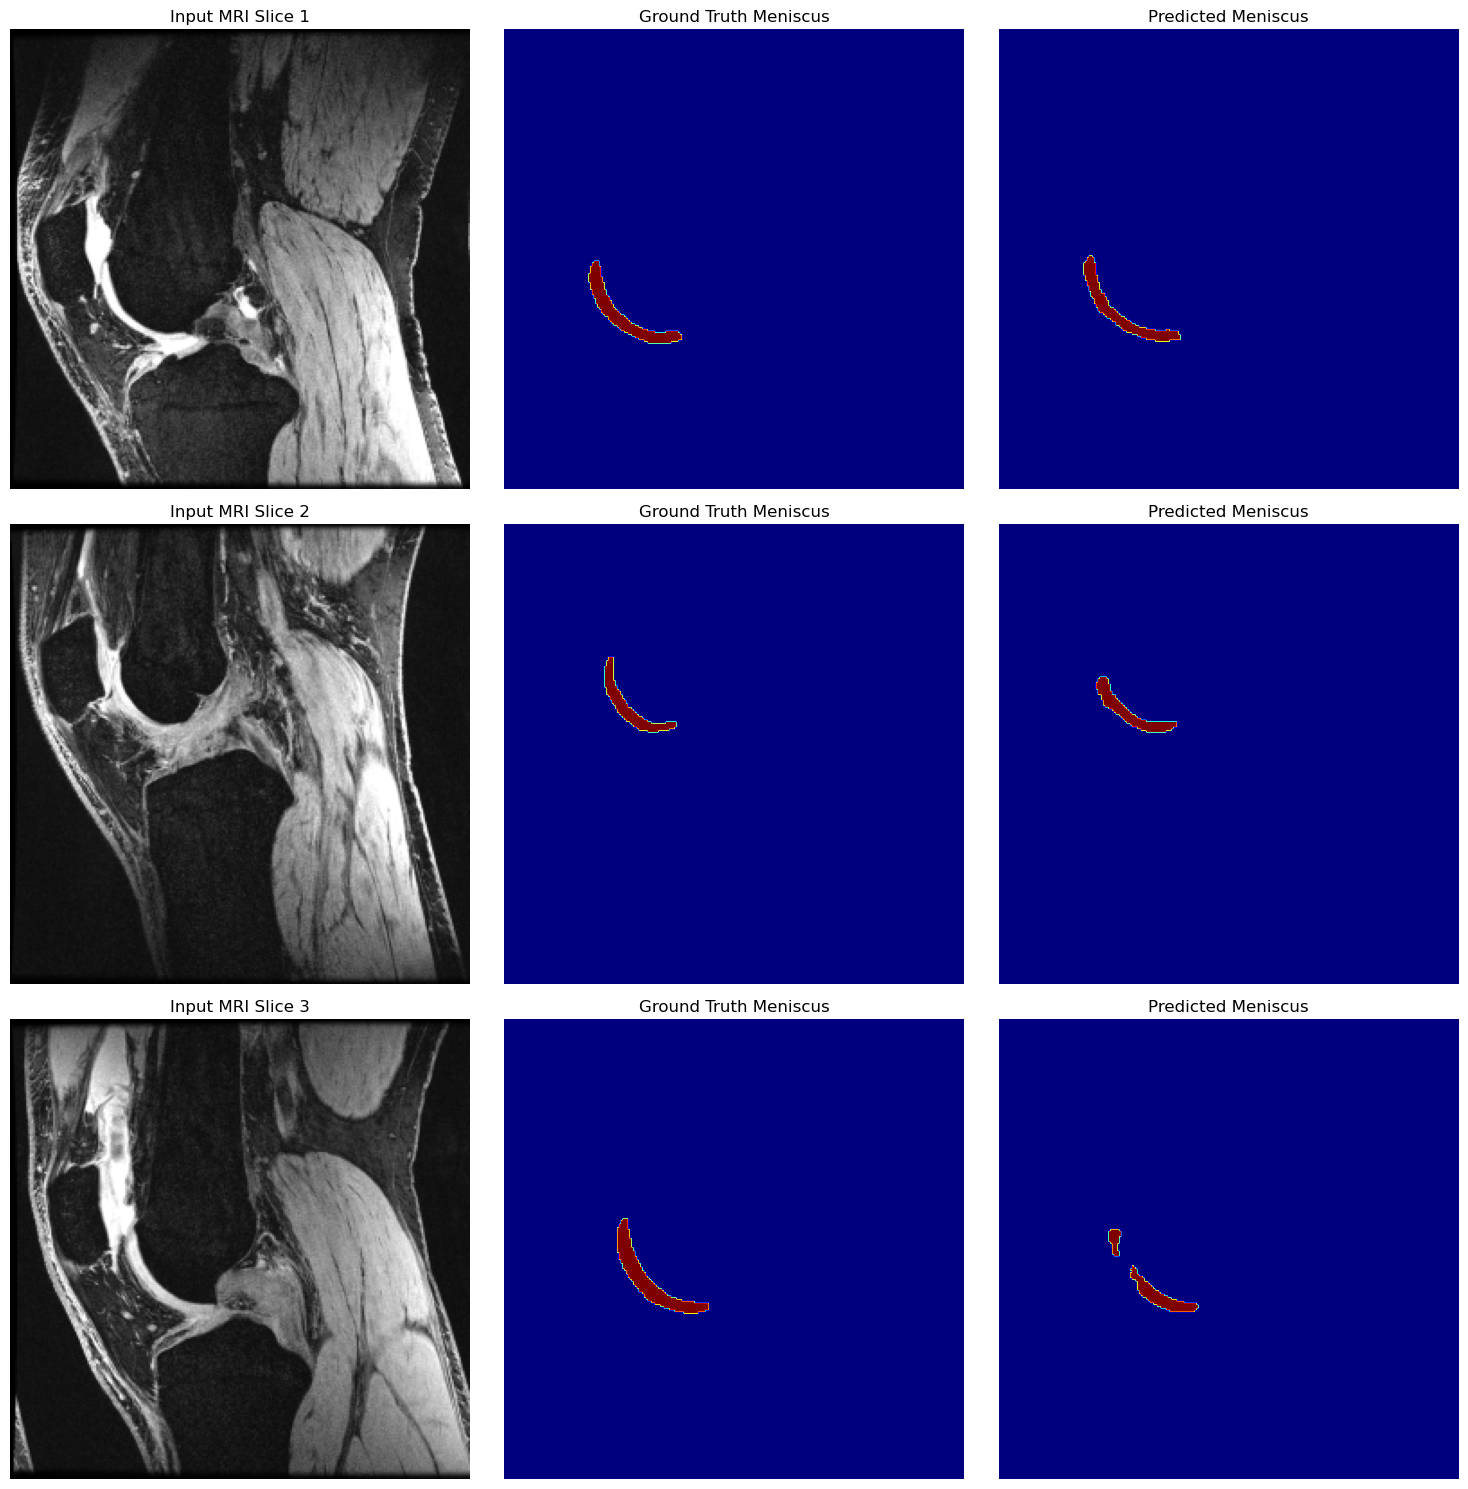

In [8]:
# ============== IMPORTS & CONFIGURATION ==============
import os
import shutil
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import zoom, binary_closing
from skimage.morphology import remove_small_objects
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics

# Configuration
DICOM_ROOT = os.path.normpath(r"F:\skm-tea-data\Dicom Data")
NIFTI_ROOT = os.path.normpath(r"F:\skm-tea-data\Named Raw Segmented Data")
PREPROCESSED_DIR = "preprocessed_meniscus_final"
TARGET_SHAPE = (256, 256)
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-4
MENISCUS_CLASS = 2  # Class 2 = medial meniscus in your data

# ============== DATA PROCESSING ==============
def process_patient(dicom_dir, nii_path, output_dir):
    """Process DICOM/NIfTI data with meniscus class extraction"""
    try:
        # Load DICOM series
        slices, positions = [], []
        for f in sorted(os.listdir(dicom_dir)):
            if f.lower().endswith('.dcm'):
                ds = pydicom.dcmread(os.path.join(dicom_dir, f))
                if not hasattr(ds, 'ImagePositionPatient'):
                    continue
                slices.append(ds.pixel_array.astype(np.float32))
                positions.append(float(ds.ImagePositionPatient[2]))
        
        if not slices:
            raise ValueError("No valid DICOM files found")
        
        # Remove duplicates and normalize
        _, unique_idx = np.unique(positions, return_index=True)
        volume = np.stack([slices[i] for i in sorted(unique_idx)])
        p2, p98 = np.percentile(volume, (2, 98))
        volume = np.clip((volume - p2) / (p98 - p2 + 1e-8), 0, 1)

        # Load and process NIfTI mask
        nii = nib.load(nii_path)
        mask = nii.get_fdata()
        mask = np.transpose(mask, (2, 0, 1))  # Sagittal orientation
        mask = (mask == MENISCUS_CLASS).astype(np.float32)  # Extract meniscus class
        
        # Resample mask to match DICOM slices
        zoom_factor = volume.shape[0] / mask.shape[0]
        mask = zoom(mask, (zoom_factor, 1, 1), order=0)

        # Process 5 central slices
        mid_idx = volume.shape[0] // 2
        processed_slices = 0
        
        for slice_idx in range(max(0, mid_idx-2), min(len(volume), mid_idx+3)):
            try:
                img = resize(volume[slice_idx], TARGET_SHAPE).astype(np.float32)
                msk = resize(mask[slice_idx], TARGET_SHAPE, order=0, preserve_range=True)
                
                # Post-processing
                msk = binary_closing(msk, structure=np.ones((3,3)))
                msk = remove_small_objects(msk.astype(bool), min_size=10).astype(np.float32)
                
                if np.sum(msk) < 10:  # Minimum 10 pixels for meniscus
                    continue
                
                # Save processed data
                pid = os.path.basename(dicom_dir)
                np.save(f"{output_dir}/img_{pid}_s{slice_idx}.npy", img)
                np.save(f"{output_dir}/msk_{pid}_s{slice_idx}.npy", msk)
                processed_slices += 1
                
            except Exception as e:
                print(f"Error processing slice {slice_idx}: {str(e)}")
                continue

        return processed_slices > 0
        
    except Exception as e:
        print(f"Error processing {os.path.basename(dicom_dir)}: {str(e)}")
        return False

# ============== DATA GENERATOR ==============
class MeniscusDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, augment=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.img_paths) // BATCH_SIZE
    
    def __getitem__(self, idx):
        batch_x = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        batch_y = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        
        for i in range(BATCH_SIZE):
            index = idx * BATCH_SIZE + i
            if index >= len(self.img_paths):
                break
                
            batch_x[i,...,0] = np.load(self.img_paths[index])
            batch_y[i,...,0] = np.load(self.mask_paths[index])
            
        if self.augment:
            batch_x, batch_y = self.augment_batch(batch_x, batch_y)
            
        return batch_x, batch_y
    
    def augment_batch(self, x, y):
        """Apply random flips and rotations"""
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=2)
            y = np.flip(y, axis=2)
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=1)
            y = np.flip(y, axis=1)
        return x, y
    
    def on_epoch_end(self):
        indices = np.arange(len(self.img_paths))
        np.random.shuffle(indices)
        self.img_paths = [self.img_paths[i] for i in indices]
        self.mask_paths = [self.mask_paths[i] for i in indices]

# ============== MODEL ARCHITECTURE ==============
def build_unet():
    inputs = tf.keras.Input((*TARGET_SHAPE, 1))
    
    # Encoder
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    # Bottleneck
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Decoder
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# ============== VISUALIZATION & EVALUATION ==============
def visualize_predictions(model, generator, num_samples=3):
    x, y_true = generator[0]
    y_pred = model.predict(x)
    
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Original DICOM
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(x[i,...,0], cmap='gray')
        plt.title(f"Input MRI Slice {i+1}")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(y_true[i,...,0], cmap='jet', vmin=0, vmax=1)
        plt.title("Ground Truth Meniscus")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_samples, 3, i*3+3)
        pred = (y_pred[i,...,0] > 0.5).astype(float)
        plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
        plt.title("Predicted Meniscus")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(model, generator):
    x, y_true = generator[0]
    y_pred = model.predict(x)
    y_pred_bin = (y_pred > 0.5).astype(np.float32)
    
    # Dice Coefficient
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin)
    dice = (2 * intersection) / (union + 1e-7)
    
    # IoU
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - intersection
    iou = intersection / (union + 1e-7)
    
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"IoU: {iou:.4f}")

# ============== TRAINING PIPELINE ==============
def main():
    # Preprocess data
    if os.path.exists(PREPROCESSED_DIR):
        shutil.rmtree(PREPROCESSED_DIR)
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)
    
    processed = 0
    for pid in os.listdir(DICOM_ROOT):
        dicom_path = os.path.join(DICOM_ROOT, pid)
        nii_path = os.path.join(NIFTI_ROOT, f"{pid}.nii")
        if os.path.exists(nii_path) and process_patient(dicom_path, nii_path, PREPROCESSED_DIR):
            processed += 1
    print(f"Processed {processed} patients with valid data")

    # Prepare datasets
    img_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("img_")])
    msk_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("msk_")])
    
    split = int(0.8 * len(img_paths))
    train_gen = MeniscusDataGenerator(img_paths[:split], msk_paths[:split])
    val_gen = MeniscusDataGenerator(img_paths[split:], msk_paths[split:], augment=False)

    # Build and compile model
    model = build_unet()
    model.compile(
        optimizer=optimizers.Adam(LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[metrics.MeanIoU(num_classes=2)]
    )

    # Train with callbacks
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[
            callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
        ]
    )


    # Save trained model
    model.save("trained_attention_unet.h5")
    print("Model successfully saved as 'trained_attention_unet.h5'")

    # Evaluate and visualize
    print("\n=== Validation Set Performance ===")
    calculate_metrics(model, val_gen)
    visualize_predictions(model, val_gen)

if __name__ == "__main__":
    main()


In [11]:
import tensorflow as tf

# Load pre-trained model
model = tf.keras.models.load_model("trained_attention_unet.h5", compile=False)
print("Model loaded successfully!")


Model loaded successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

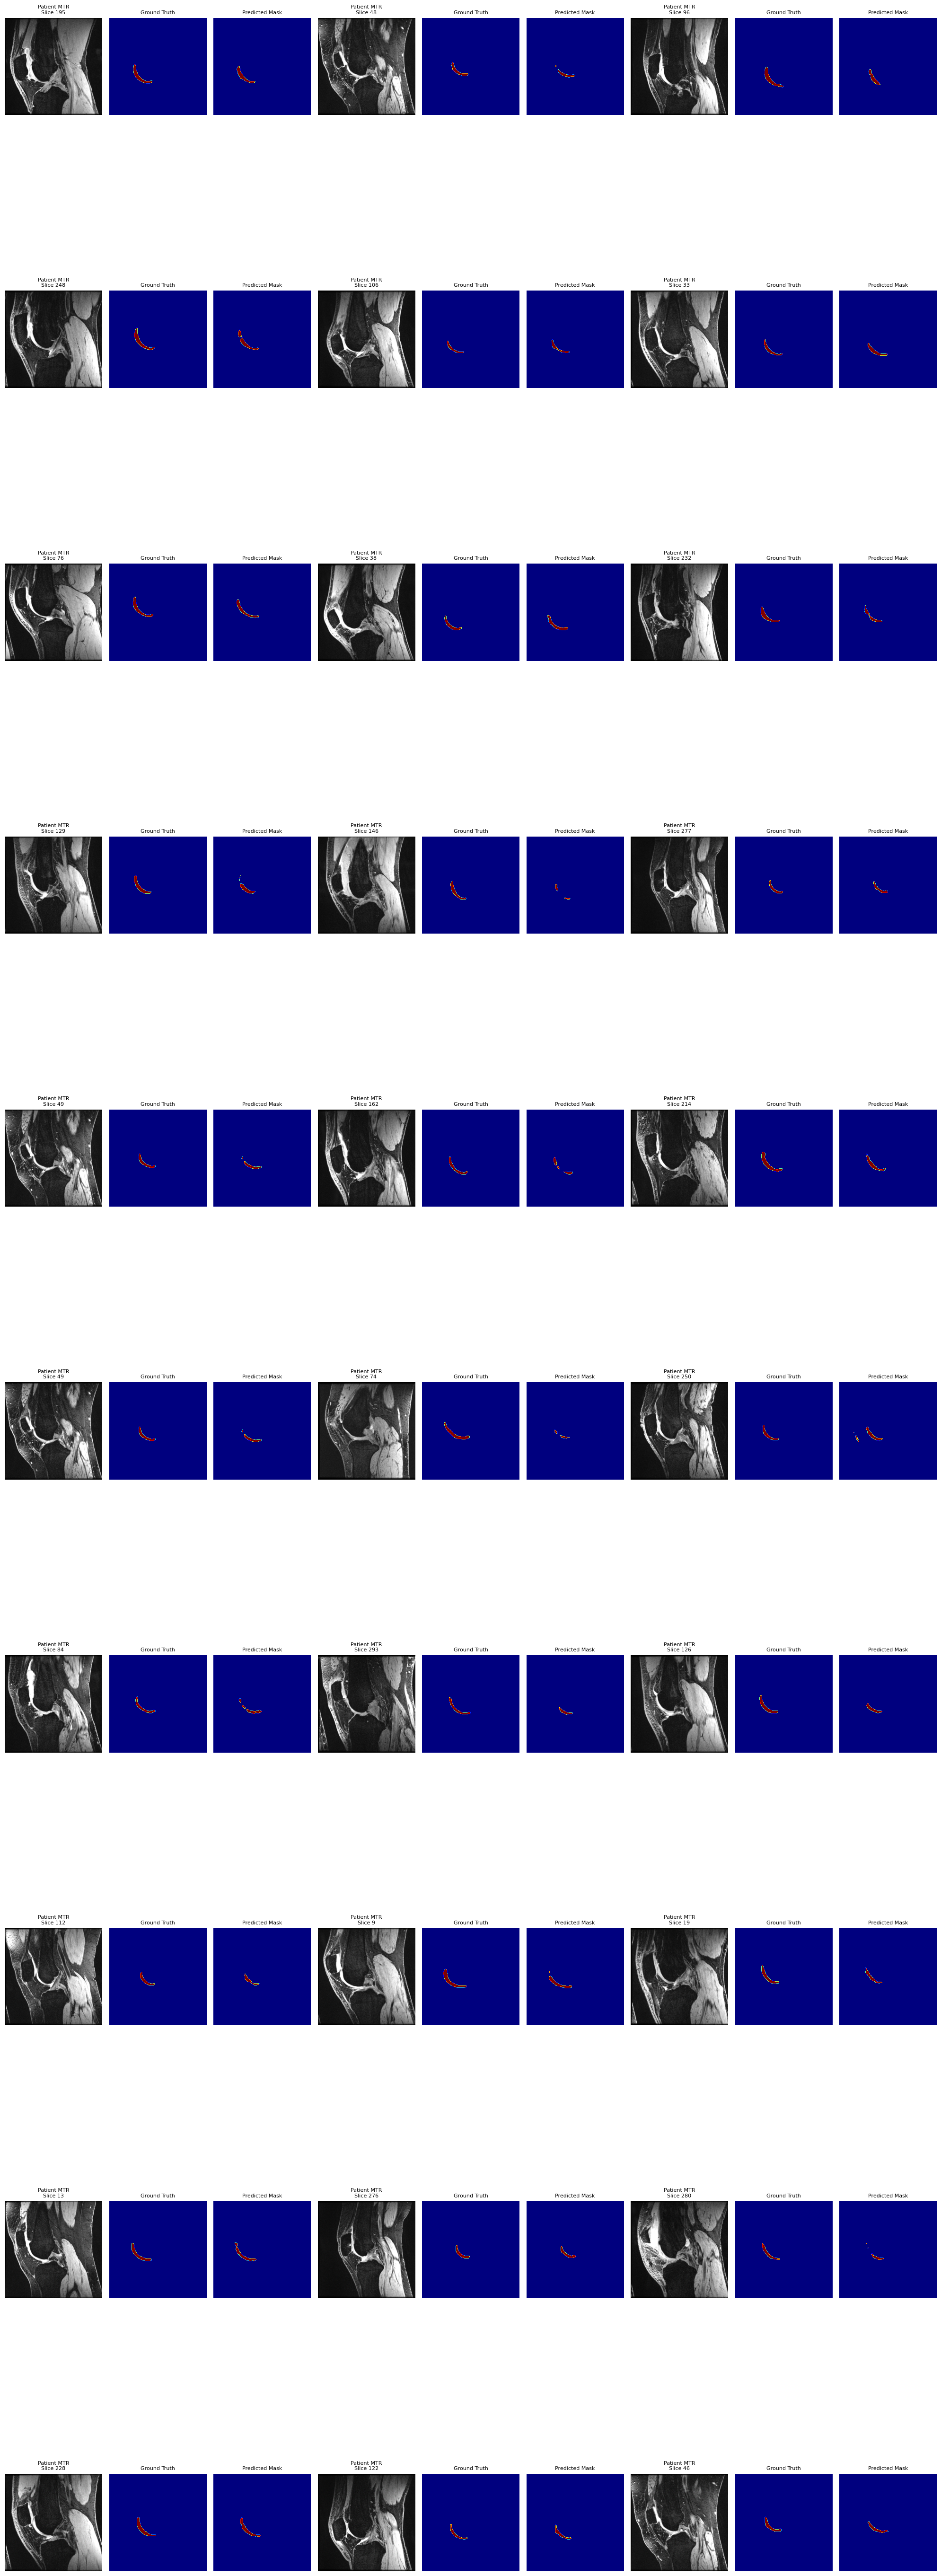

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained model
model = tf.keras.models.load_model("trained_attention_unet.h5", compile=False)

# Load preprocessed data paths
img_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                    for f in os.listdir(PREPROCESSED_DIR) if f.startswith("img_")])
msk_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                    for f in os.listdir(PREPROCESSED_DIR) if f.startswith("msk_")])


def visualize_10_cases(model, img_paths, msk_paths):
    # Get unique patient IDs
    patient_ids = list(set([os.path.basename(p).split('_')[1] for p in img_paths]))
    selected_pids = np.random.choice(patient_ids, 10, replace=True)

    plt.figure(figsize=(20, 60))
    plt_idx = 1
    
    for pid in selected_pids:
        # Get all slices for selected patient
        patient_imgs = [p for p in img_paths if f'_{pid}_' in p]
        patient_msks = [p for p in msk_paths if f'_{pid}_' in p]
        
        # Select 3 random slices
        selected_slices = np.random.choice(len(patient_imgs), 3, replace=False)
        
        for slice_idx in selected_slices:
            img = np.load(patient_imgs[slice_idx])
            mask = np.load(patient_msks[slice_idx])
            pred = model.predict(np.expand_dims(img[..., np.newaxis], axis=0))
            pred_bin = (pred > 0.5).astype(float)[0,...,0]

            # Original Image
            plt.subplot(10, 9, plt_idx)
            plt.imshow(img, cmap='gray')
            plt.title(f"Patient {pid}\nSlice {slice_idx}", fontsize=8)
            plt.axis('off')
            plt_idx +=1

            # Ground Truth
            plt.subplot(10, 9, plt_idx)
            plt.imshow(mask, cmap='jet', vmin=0, vmax=1)
            plt.title("Ground Truth", fontsize=8)
            plt.axis('off')
            plt_idx +=1

            # Prediction
            plt.subplot(10, 9, plt_idx)
            plt.imshow(pred_bin, cmap='jet', vmin=0, vmax=1)
            plt.title("Predicted Mask", fontsize=8)
            plt.axis('off')
            plt_idx +=1

    plt.tight_layout()
    plt.show()

# Call visualization function
visualize_10_cases(model, img_paths, msk_paths)


In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load pre-trained model
model = tf.keras.models.load_model("trained_attention_unet.h5", compile=False)
print("Model loaded successfully!")


Model loaded successfully!


Model loaded successfully!
Validation generator created with 15 batches

Evaluating model on validation set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Average Metrics:
Dice: 0.7219
IoU: 0.5752
Precision: 0.8445
Recall: 0.6507


C:\Users\Lakshminath\AppData\Local\Temp\ipykernel_17080\4151925199.py:132: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dice_scores, iou_scores], labels=["Dice", "IoU"])


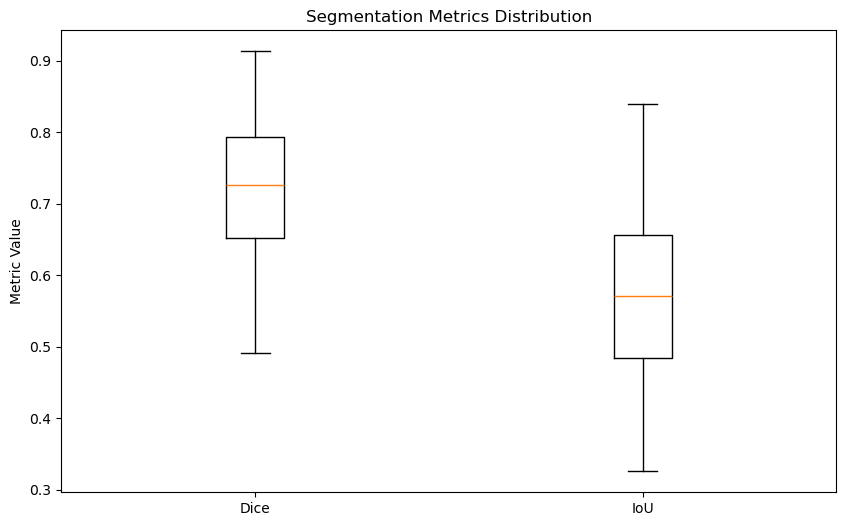

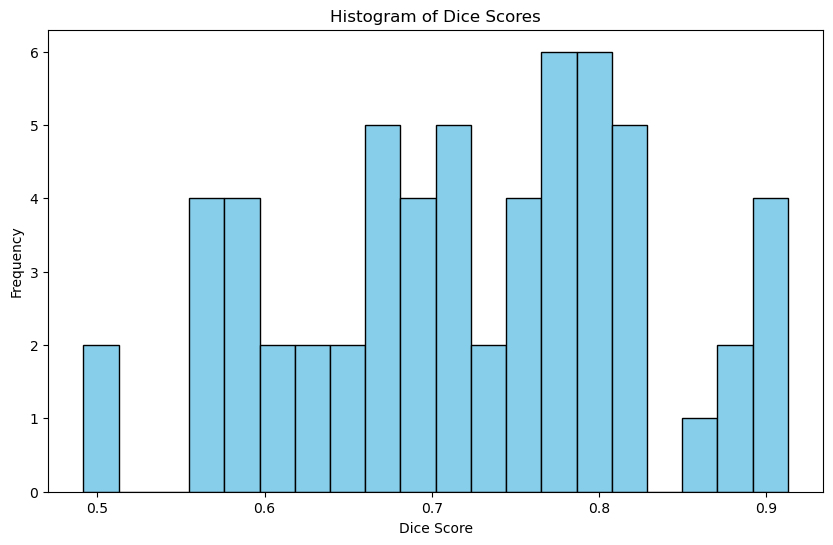

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, jaccard_score
import tensorflow as tf

# 1. Load Model
model = tf.keras.models.load_model("trained_attention_unet.h5", compile=False)
print("Model loaded successfully!")

# 2. Prepare Validation Data
PREPROCESSED_DIR = "preprocessed_meniscus_final"  # Ensure this matches your directory

# Load preprocessed file paths
img_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                   for f in os.listdir(PREPROCESSED_DIR) if f.startswith("img_")])
msk_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                   for f in os.listdir(PREPROCESSED_DIR) if f.startswith("msk_")])

# Split into validation set
split = int(0.8 * len(img_paths))
val_img_paths = img_paths[split:]
val_msk_paths = msk_paths[split:]

# Define Custom Data Generator (if not already defined)
class MeniscusDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=4, augment=False):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_img_paths = self.img_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[index * self.batch_size:(index + 1) * self.batch_size]

        x_batch = np.array([np.load(p)[..., np.newaxis] for p in batch_img_paths])
        y_batch = np.array([np.load(p)[..., np.newaxis] for p in batch_mask_paths])

        if self.augment:
            x_batch, y_batch = self.augment_batch(x_batch, y_batch)

        return x_batch, y_batch

    def augment_batch(self, x, y):
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=2)
            y = np.flip(y, axis=2)
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=1)
            y = np.flip(y, axis=1)
        return x, y

# Create validation generator
val_gen = MeniscusDataGenerator(val_img_paths, val_msk_paths, augment=False)
print(f"Validation generator created with {len(val_gen)} batches")

# 3. Define Metrics Functions
def calculate_metrics(y_true, y_pred):
    """
    Calculate segmentation metrics.
    Args:
        y_true: Ground truth binary mask (numpy array).
        y_pred: Predicted binary mask (numpy array).
    Returns:
        Dictionary of metrics.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    intersection = np.sum(y_true_flat * y_pred_flat)
    dice = (2 * intersection) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + 1e-7)
    iou = jaccard_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    
    return {"Dice": dice, "IoU": iou, "Precision": precision, "Recall": recall}

def evaluate_model_on_validation(model, val_gen):
    """
    Evaluate model performance on the validation set.
    Args:
        model: Trained model.
        val_gen: Validation data generator.
    Returns:
        List of metrics for each sample.
    """
    metrics_list = []
    for i in range(len(val_gen)):
        x_batch, y_batch = val_gen[i]
        y_pred_batch = model.predict(x_batch)
        for j in range(len(x_batch)):
            y_pred_bin = (y_pred_batch[j,...,0] > 0.5).astype(np.float32)
            y_true_bin = y_batch[j,...,0]
            metrics = calculate_metrics(y_true_bin, y_pred_bin)
            metrics_list.append(metrics)
    return metrics_list

# 4. Aggregate Metrics and Display Results
def aggregate_metrics(metrics_list):
    """
    Aggregate and display average metrics.
    Args:
        metrics_list: List of dictionaries containing individual sample metrics.
    """
    avg_metrics = {
        "Dice": np.mean([m["Dice"] for m in metrics_list]),
        "IoU": np.mean([m["IoU"] for m in metrics_list]),
        "Precision": np.mean([m["Precision"] for m in metrics_list]),
        "Recall": np.mean([m["Recall"] for m in metrics_list])
    }
    
    print("\nAverage Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

# 5. Plot Visualizations
def plot_boxplots(metrics_list):
    """
    Plot boxplots of segmentation metrics.
    Args:
        metrics_list: List of dictionaries containing individual sample metrics.
    """
    dice_scores = [m["Dice"] for m in metrics_list]
    iou_scores = [m["IoU"] for m in metrics_list]
    
    plt.figure(figsize=(10, 6))
    
    plt.boxplot([dice_scores, iou_scores], labels=["Dice", "IoU"])
    
    plt.title("Segmentation Metrics Distribution")
    plt.ylabel("Metric Value")
    
    plt.show()

def plot_histogram(metrics_list):
    """
    Plot histogram of Dice scores.
    Args:
        metrics_list: List of dictionaries containing individual sample metrics.
    """
    dice_scores = [m["Dice"] for m in metrics_list]
    
    plt.figure(figsize=(10, 6))
    
    plt.hist(dice_scores, bins=20, color='skyblue', edgecolor='black')
    
    plt.title("Histogram of Dice Scores")
    plt.xlabel("Dice Score")
    plt.ylabel("Frequency")
    
    plt.show()

# 6. Evaluate Model and Visualize Results
print("\nEvaluating model on validation set...")
metrics_list = evaluate_model_on_validation(model, val_gen)

# Display average metrics
aggregate_metrics(metrics_list)

# Plot boxplots of Dice and IoU scores
plot_boxplots(metrics_list)

# Plot histogram of Dice scores
plot_histogram(metrics_list)


Processed 60 patients with valid data
Epoch 1/50


C:\Users\Lakshminath\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - loss: 0.3320 - mean_io_u_2: 0.4965 - val_loss: 0.4142 - val_mean_io_u_2: 0.4965
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 333ms/step - loss: 0.1655 - mean_io_u_2: 0.4965 - val_loss: 0.2435 - val_mean_io_u_2: 0.4965
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 332ms/step - loss: 0.1211 - mean_io_u_2: 0.4965 - val_loss: 0.1600 - val_mean_io_u_2: 0.4965
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 337ms/step - loss: 0.0959 - mean_io_u_2: 0.4965 - val_loss: 0.1140 - val_mean_io_u_2: 0.4965
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 26s 431ms/step - loss: 0.0781 - mean_io_u_2: 0.4965 - val_loss: 0.0855 - val_mean_io_u_2: 0.4965
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 590ms/step - loss: 0.0651 - mean_io_u_2: 0.4964 - val_loss: 0.0767 - val_mean_io_u_2: 0.4965
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 36s 606ms/step - loss: 0.0558 - mean_io_u_2: 0.4965 - val_loss: 0.0630 - val_mean_io_u_2: 0.4965
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 587ms/step - loss: 0.048

Model successfully saved as 'trained_attention_unet.h5'


KeyError: 'mean_io_u'

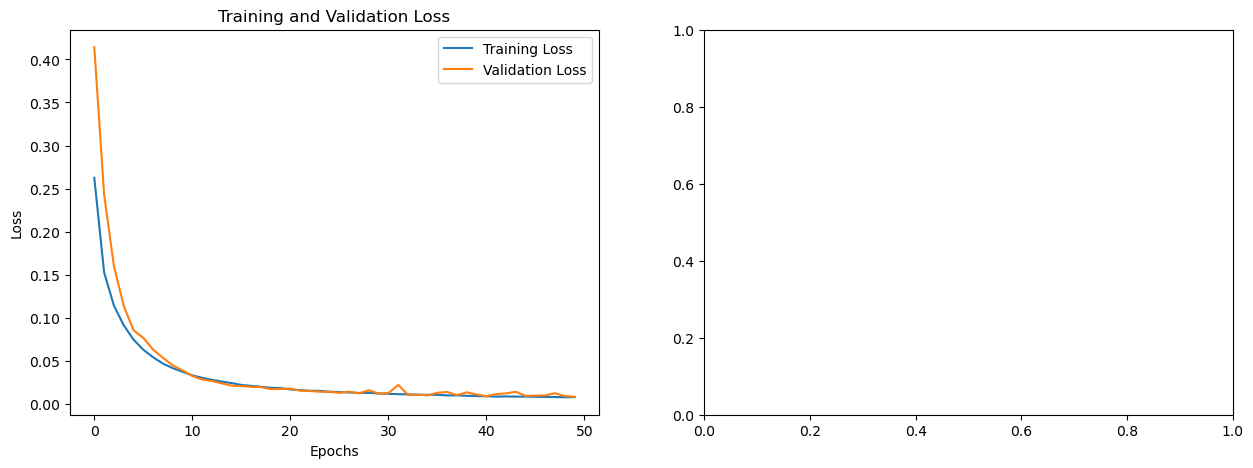

In [30]:
# ============== IMPORTS & CONFIGURATION ==============
import os
import shutil
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import zoom, binary_closing
from skimage.morphology import remove_small_objects
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics

# Configuration
DICOM_ROOT = os.path.normpath(r"F:\skm-tea-data\Dicom Data")
NIFTI_ROOT = os.path.normpath(r"F:\skm-tea-data\Named Raw Segmented Data")
PREPROCESSED_DIR = "preprocessed_meniscus_final"
TARGET_SHAPE = (256, 256)
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-4
MENISCUS_CLASS = 2  # Class 2 = medial meniscus in your data

# ============== DATA PROCESSING ==============
def process_patient(dicom_dir, nii_path, output_dir):
    """Process DICOM/NIfTI data with meniscus class extraction"""
    try:
        # Load DICOM series
        slices, positions = [], []
        for f in sorted(os.listdir(dicom_dir)):
            if f.lower().endswith('.dcm'):
                ds = pydicom.dcmread(os.path.join(dicom_dir, f))
                if not hasattr(ds, 'ImagePositionPatient'):
                    continue
                slices.append(ds.pixel_array.astype(np.float32))
                positions.append(float(ds.ImagePositionPatient[2]))
        
        if not slices:
            raise ValueError("No valid DICOM files found")
        
        # Remove duplicates and normalize
        _, unique_idx = np.unique(positions, return_index=True)
        volume = np.stack([slices[i] for i in sorted(unique_idx)])
        p2, p98 = np.percentile(volume, (2, 98))
        volume = np.clip((volume - p2) / (p98 - p2 + 1e-8), 0, 1)

        # Load and process NIfTI mask
        nii = nib.load(nii_path)
        mask = nii.get_fdata()
        mask = np.transpose(mask, (2, 0, 1))  # Sagittal orientation
        mask = (mask == MENISCUS_CLASS).astype(np.float32)  # Extract meniscus class
        
        # Resample mask to match DICOM slices
        zoom_factor = volume.shape[0] / mask.shape[0]
        mask = zoom(mask, (zoom_factor, 1, 1), order=0)

        # Process 5 central slices
        mid_idx = volume.shape[0] // 2
        processed_slices = 0
        
        for slice_idx in range(max(0, mid_idx-2), min(len(volume), mid_idx+3)):
            try:
                img = resize(volume[slice_idx], TARGET_SHAPE).astype(np.float32)
                msk = resize(mask[slice_idx], TARGET_SHAPE, order=0, preserve_range=True)
                
                # Post-processing
                msk = binary_closing(msk, structure=np.ones((3,3)))
                msk = remove_small_objects(msk.astype(bool), min_size=10).astype(np.float32)
                
                if np.sum(msk) < 10:  # Minimum 10 pixels for meniscus
                    continue
                
                # Save processed data
                pid = os.path.basename(dicom_dir)
                np.save(f"{output_dir}/img_{pid}_s{slice_idx}.npy", img)
                np.save(f"{output_dir}/msk_{pid}_s{slice_idx}.npy", msk)
                processed_slices += 1
                
            except Exception as e:
                print(f"Error processing slice {slice_idx}: {str(e)}")
                continue

        return processed_slices > 0
        
    except Exception as e:
        print(f"Error processing {os.path.basename(dicom_dir)}: {str(e)}")
        return False

# ============== DATA GENERATOR ==============
class MeniscusDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, augment=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.img_paths) // BATCH_SIZE
    
    def __getitem__(self, idx):
        batch_x = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        batch_y = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        
        for i in range(BATCH_SIZE):
            index = idx * BATCH_SIZE + i
            if index >= len(self.img_paths):
                break
                
            batch_x[i,...,0] = np.load(self.img_paths[index])
            batch_y[i,...,0] = np.load(self.mask_paths[index])
            
        if self.augment:
            batch_x, batch_y = self.augment_batch(batch_x, batch_y)
            
        return batch_x, batch_y
    
    def augment_batch(self, x, y):
        """Apply random flips and rotations"""
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=2)
            y = np.flip(y, axis=2)
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=1)
            y = np.flip(y, axis=1)
        return x, y
    
    def on_epoch_end(self):
        indices = np.arange(len(self.img_paths))
        np.random.shuffle(indices)
        self.img_paths = [self.img_paths[i] for i in indices]
        self.mask_paths = [self.mask_paths[i] for i in indices]

# ============== MODEL ARCHITECTURE ==============
def build_unet():
    inputs = tf.keras.Input((*TARGET_SHAPE, 1))
    
    # Encoder
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    # Bottleneck
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Decoder
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# ============== VISUALIZATION & EVALUATION ==============
def plot_training_history(history):
    """Plot training and validation metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot IoU
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mean_io_u'], label='Training IoU')
    plt.plot(history.history['val_mean_io_u'], label='Validation IoU')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def visualize_orthogonal_views(model, patient_id):
    """Visualize axial, coronal and sagittal views with predictions"""
    # Load all slices for the patient
    img_files = sorted([f for f in os.listdir(PREPROCESSED_DIR) 
                       if f.startswith(f"img_{patient_id}_")])
    msk_files = sorted([f for f in os.listdir(PREPROCESSED_DIR)
                       if f.startswith(f"msk_{patient_id}_")])
    
    # Load and stack slices into 3D volume
    img_volume = np.stack([np.load(os.path.join(PREPROCESSED_DIR, f)) for f in img_files])
    msk_volume = np.stack([np.load(os.path.join(PREPROCESSED_DIR, f)) for f in msk_files])
    
    # Get mid slices for each plane
    axial_idx = img_volume.shape[0] // 2
    coronal_idx = img_volume.shape[1] // 2
    sagittal_idx = img_volume.shape[2] // 2
    
    # Create predictions
    pred_volume = np.zeros_like(img_volume)
    for i in range(img_volume.shape[0]):
        pred = model.predict(img_volume[i][..., np.newaxis][np.newaxis, ...])
        pred_volume[i] = (pred[0,...,0] > 0.5).astype(float)
    
    # Plot settings
    plt.figure(figsize=(15, 10))
    planes = [
        ('Axial', img_volume[axial_idx], msk_volume[axial_idx], pred_volume[axial_idx]),
        ('Coronal', img_volume[:, coronal_idx], msk_volume[:, coronal_idx], pred_volume[:, coronal_idx]),
        ('Sagittal', img_volume[:, :, sagittal_idx].T, msk_volume[:, :, sagittal_idx].T, pred_volume[:, :, sagittal_idx].T)
    ]
    
    for idx, (title, img, msk, pred) in enumerate(planes):
        # Original Image
        plt.subplot(3, 3, idx*3+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} - Original")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(3, 3, idx*3+2)
        plt.imshow(msk, cmap='jet', vmin=0, vmax=1)
        plt.title(f"{title} - Ground Truth")
        plt.axis('off')
        
        # Prediction
        plt.subplot(3, 3, idx*3+3)
        plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
        plt.title(f"{title} - Prediction")
        plt.axis('off')
    
    plt.suptitle(f"Orthogonal Views for Patient {patient_id}", y=0.95)
    plt.tight_layout()
    plt.show()

# ============== TRAINING PIPELINE ==============
def main():
    # Preprocess data
    if os.path.exists(PREPROCESSED_DIR):
        shutil.rmtree(PREPROCESSED_DIR)
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)
    
    processed = 0
    for pid in os.listdir(DICOM_ROOT):
        dicom_path = os.path.join(DICOM_ROOT, pid)
        nii_path = os.path.join(NIFTI_ROOT, f"{pid}.nii")
        if os.path.exists(nii_path) and process_patient(dicom_path, nii_path, PREPROCESSED_DIR):
            processed += 1
    print(f"Processed {processed} patients with valid data")

    # Prepare datasets
    img_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("img_")])
    msk_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("msk_")])
    
    split = int(0.8 * len(img_paths))
    train_gen = MeniscusDataGenerator(img_paths[:split], msk_paths[:split])
    val_gen = MeniscusDataGenerator(img_paths[split:], msk_paths[split:], augment=False)

    # Build and compile model
    model = build_unet()
    model.compile(
        optimizer=optimizers.Adam(LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[metrics.MeanIoU(num_classes=2)]
    )

    # Train with callbacks
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[
            callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
        ]
    )

    # Save trained model
    model.save("trained_attention_unet.h5")
    print("Model successfully saved as 'trained_attention_unet.h5'")

    # Plot training history
    plot_training_history(history)

    # Visualize predictions
    print("\n=== Validation Set Performance ===")
    sample_patient = os.listdir(DICOM_ROOT)[0]  # Get first patient ID
    visualize_orthogonal_views(model, sample_patient)

if __name__ == "__main__":
    main()


Processed 60 patients with valid data
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - loss: 0.2971 - mean_io_u_3: 0.4965 - val_loss: 0.4563 - val_mean_io_u_3: 0.4965
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - loss: 0.1418 - mean_io_u_3: 0.4964 - val_loss: 0.3105 - val_mean_io_u_3: 0.4965
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 330ms/step - loss: 0.1010 - mean_io_u_3: 0.4965 - val_loss: 0.2001 - val_mean_io_u_3: 0.4965
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 327ms/step - loss: 0.0779 - mean_io_u_3: 0.4964 - val_loss: 0.1083 - val_mean_io_u_3: 0.4965
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 331ms/step - loss: 0.0641 - mean_io_u_3: 0.4964 - val_loss: 0.0761 - val_mean_io_u_3: 0.4965
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - loss: 0.0536 - mean_io_u_3: 0.4965 - val_loss: 0.0611 - val_mean_io_u_3: 0.4965
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 329ms/step - loss: 0.0469 - mean_io_u_3: 0.4965 - val_loss: 0.0514 - val_mean_io_u_3: 0.4965
Epoch 8/50
60/60 

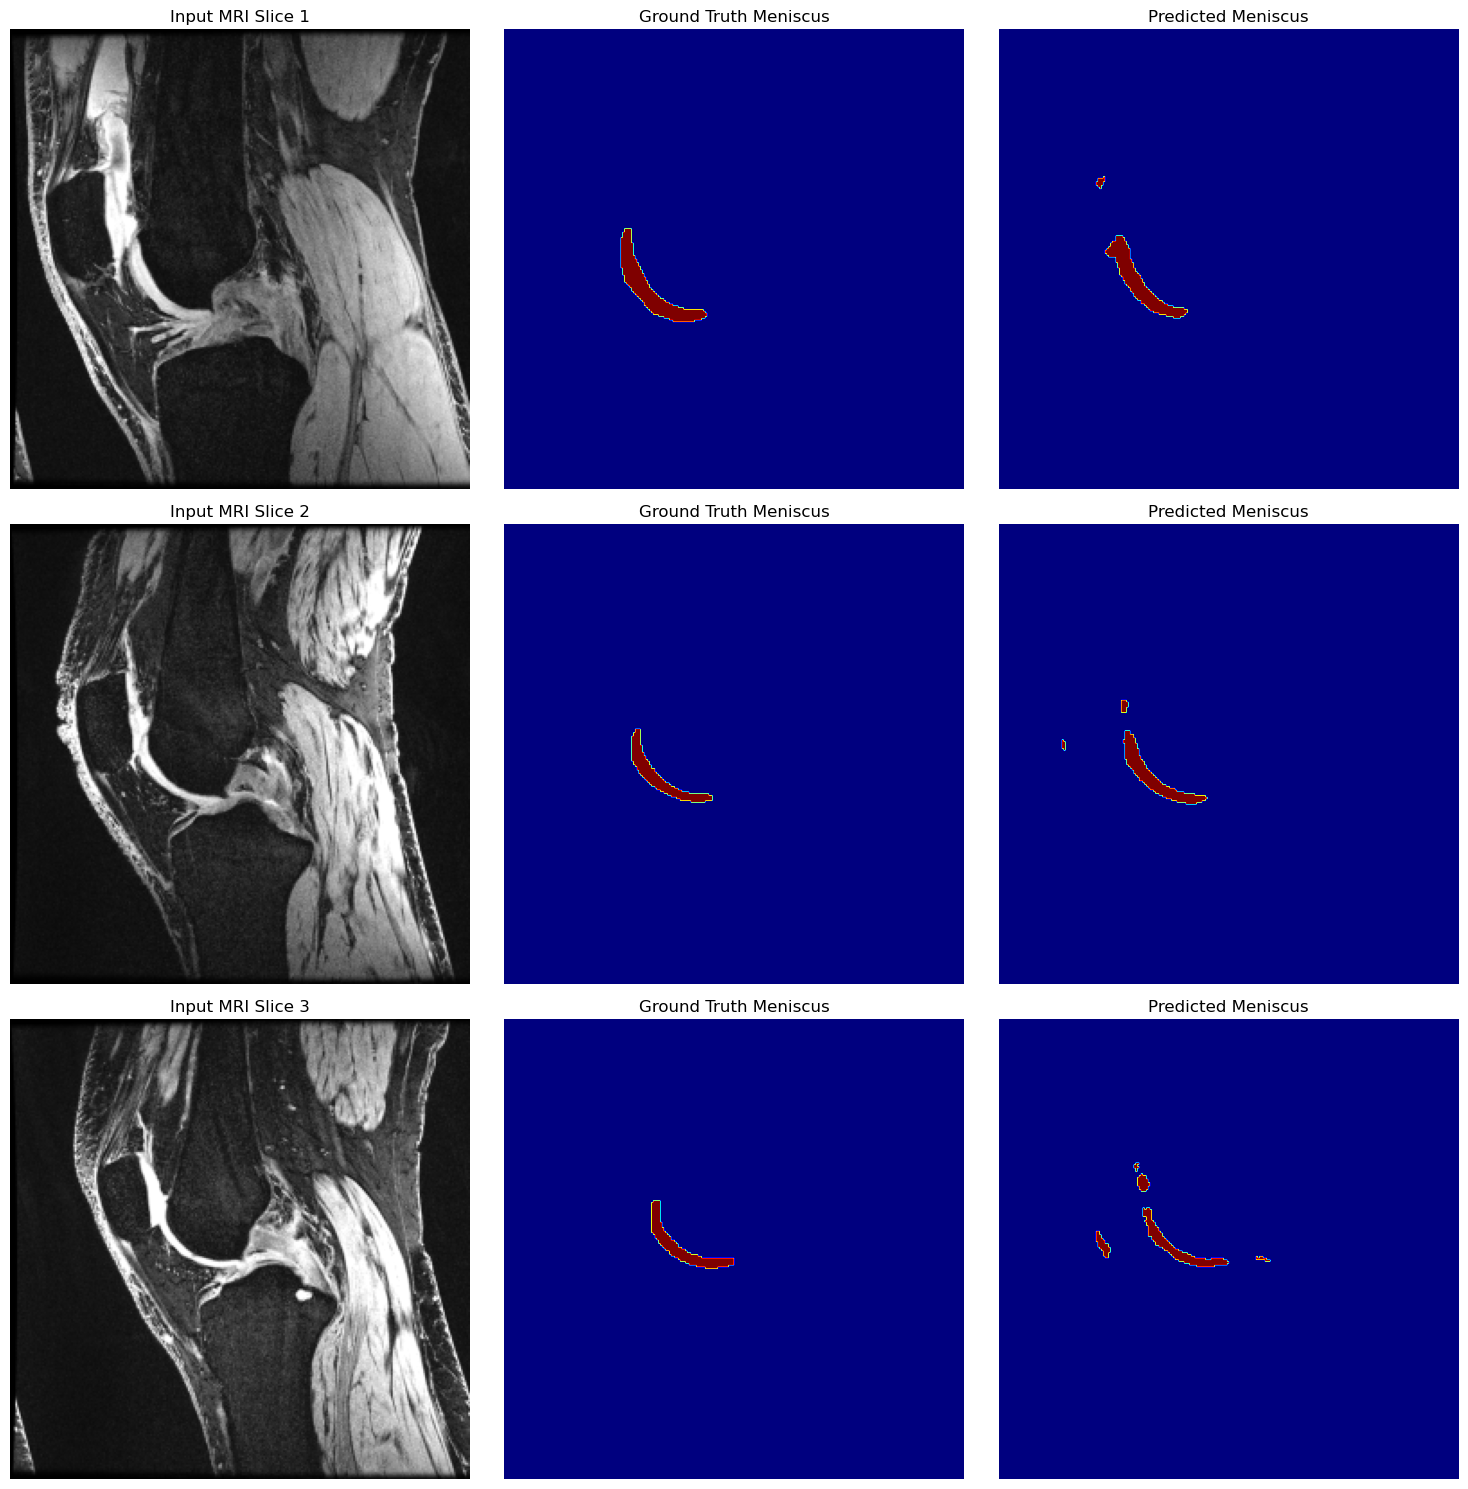

In [36]:
# ============== IMPORTS & CONFIGURATION ==============
import os
import shutil
import numpy as np
import pydicom
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
from scipy.ndimage import zoom, binary_closing
from skimage.morphology import remove_small_objects
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics

# Configuration
DICOM_ROOT = os.path.normpath(r"F:\skm-tea-data\Dicom Data")
NIFTI_ROOT = os.path.normpath(r"F:\skm-tea-data\Named Raw Segmented Data")
PREPROCESSED_DIR = "preprocessed_meniscus_final"
TARGET_SHAPE = (256, 256)
BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 3e-4
MENISCUS_CLASS = 2  # Class 2 = medial meniscus in your data

# ============== DATA PROCESSING ==============
def process_patient(dicom_dir, nii_path, output_dir):
    """Process DICOM/NIfTI data with meniscus class extraction"""
    try:
        # Load DICOM series
        slices, positions = [], []
        for f in sorted(os.listdir(dicom_dir)):
            if f.lower().endswith('.dcm'):
                ds = pydicom.dcmread(os.path.join(dicom_dir, f))
                if not hasattr(ds, 'ImagePositionPatient'):
                    continue
                slices.append(ds.pixel_array.astype(np.float32))
                positions.append(float(ds.ImagePositionPatient[2]))
        
        if not slices:
            raise ValueError("No valid DICOM files found")
        
        # Remove duplicates and normalize
        _, unique_idx = np.unique(positions, return_index=True)
        volume = np.stack([slices[i] for i in sorted(unique_idx)])
        p2, p98 = np.percentile(volume, (2, 98))
        volume = np.clip((volume - p2) / (p98 - p2 + 1e-8), 0, 1)

        # Load and process NIfTI mask
        nii = nib.load(nii_path)
        mask = nii.get_fdata()
        mask = np.transpose(mask, (2, 0, 1))  # Sagittal orientation
        mask = (mask == MENISCUS_CLASS).astype(np.float32)
        
        # Resample mask to match DICOM slices
        zoom_factor = volume.shape[0] / mask.shape[0]
        mask = zoom(mask, (zoom_factor, 1, 1), order=0)

        # Process 5 central slices
        mid_idx = volume.shape[0] // 2
        processed_slices = 0
        
        for slice_idx in range(max(0, mid_idx-2), min(len(volume), mid_idx+3)):
            try:
                img = resize(volume[slice_idx], TARGET_SHAPE).astype(np.float32)
                msk = resize(mask[slice_idx], TARGET_SHAPE, order=0, preserve_range=True)
                
                # Post-processing
                msk = binary_closing(msk, structure=np.ones((3,3)))
                msk = remove_small_objects(msk.astype(bool), min_size=10).astype(np.float32)
                
                if np.sum(msk) < 10:  # Minimum 10 pixels for meniscus
                    continue
                
                # Save processed data
                pid = os.path.basename(dicom_dir)
                np.save(f"{output_dir}/img_{pid}_s{slice_idx}.npy", img)
                np.save(f"{output_dir}/msk_{pid}_s{slice_idx}.npy", msk)
                processed_slices += 1
                
            except Exception as e:
                print(f"Error processing slice {slice_idx}: {str(e)}")
                continue

        return processed_slices > 0
        
    except Exception as e:
        print(f"Error processing {os.path.basename(dicom_dir)}: {str(e)}")
        return False

# ============== DATA GENERATOR ==============
class MeniscusDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, augment=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.augment = augment
        self.on_epoch_end()

    def __len__(self):
        return len(self.img_paths) // BATCH_SIZE
    
    def __getitem__(self, idx):
        batch_x = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        batch_y = np.zeros((BATCH_SIZE, *TARGET_SHAPE, 1), dtype=np.float32)
        
        for i in range(BATCH_SIZE):
            index = idx * BATCH_SIZE + i
            if index >= len(self.img_paths):
                break
                
            batch_x[i,...,0] = np.load(self.img_paths[index])
            batch_y[i,...,0] = np.load(self.mask_paths[index])
            
        if self.augment:
            batch_x, batch_y = self.augment_batch(batch_x, batch_y)
            
        return batch_x, batch_y
    
    def augment_batch(self, x, y):
        """Apply random flips and rotations"""
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=2)
            y = np.flip(y, axis=2)
        if np.random.rand() > 0.5:
            x = np.flip(x, axis=1)
            y = np.flip(y, axis=1)
        return x, y
    
    def on_epoch_end(self):
        indices = np.arange(len(self.img_paths))
        np.random.shuffle(indices)
        self.img_paths = [self.img_paths[i] for i in indices]
        self.mask_paths = [self.mask_paths[i] for i in indices]

# ============== MODEL ARCHITECTURE ==============
def build_unet():
    inputs = tf.keras.Input((*TARGET_SHAPE, 1))
    
    # Encoder
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(2)(x)
    
    # Bottleneck
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    # Decoder
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)
    
    return models.Model(inputs, outputs)

# ============== VISUALIZATION & EVALUATION ==============
def visualize_predictions(model, generator, num_samples=3):
    x, y_true = generator[0]
    y_pred = model.predict(x)
    
    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Original DICOM
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(x[i,...,0], cmap='gray')
        plt.title(f"Input MRI Slice {i+1}")
        plt.axis('off')
        
        # Ground Truth
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(y_true[i,...,0], cmap='jet', vmin=0, vmax=1)
        plt.title("Ground Truth Meniscus")
        plt.axis('off')
        
        # Prediction
        plt.subplot(num_samples, 3, i*3+3)
        pred = (y_pred[i,...,0] > 0.5).astype(float)
        plt.imshow(pred, cmap='jet', vmin=0, vmax=1)
        plt.title("Predicted Meniscus")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def calculate_metrics(model, generator):
    x, y_true = generator[0]
    y_pred = model.predict(x)
    y_pred_bin = (y_pred > 0.5).astype(np.float32)
    
    # Dice Coefficient
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin)
    dice = (2 * intersection) / (union + 1e-7)
    
    # IoU
    intersection = np.sum(y_true * y_pred_bin)
    union = np.sum(y_true) + np.sum(y_pred_bin) - intersection
    iou = intersection / (union + 1e-7)
    
    print(f"Dice Coefficient: {dice:.4f}")
    print(f"IoU: {iou:.4f}")

# ============== TRAINING PIPELINE ==============
def main():
    # Preprocess data
    if os.path.exists(PREPROCESSED_DIR):
        shutil.rmtree(PREPROCESSED_DIR)
    os.makedirs(PREPROCESSED_DIR, exist_ok=True)
    
    processed = 0
    for pid in os.listdir(DICOM_ROOT):
        dicom_path = os.path.join(DICOM_ROOT, pid)
        nii_path = os.path.join(NIFTI_ROOT, f"{pid}.nii")
        if os.path.exists(nii_path) and process_patient(dicom_path, nii_path, PREPROCESSED_DIR):
            processed += 1
    print(f"Processed {processed} patients with valid data")

    # Prepare datasets
    img_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("img_")])
    msk_paths = sorted([os.path.join(PREPROCESSED_DIR, f) 
                       for f in os.listdir(PREPROCESSED_DIR) if f.startswith("msk_")])
    
    split = int(0.8 * len(img_paths))
    train_gen = MeniscusDataGenerator(img_paths[:split], msk_paths[:split])
    val_gen = MeniscusDataGenerator(img_paths[split:], msk_paths[split:], augment=False)

    # Build and compile model
    model = build_unet()
    model.compile(
        optimizer=optimizers.Adam(LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=[metrics.MeanIoU(num_classes=2)]
    )

    # Train with callbacks
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=EPOCHS,
        callbacks=[
            callbacks.EarlyStopping(patience=15, restore_best_weights=True),
            callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)
        ]
    )

    # Save trained model
    model.save("trained_attention_unet.keras")
    print("Model successfully saved as 'trained_attention_unet.keras'")

    # Evaluate and visualize
    print("\n=== Validation Set Performance ===")
    calculate_metrics(model, val_gen)
    visualize_predictions(model, val_gen)

if __name__ == "__main__":
    main()
